Starting federated training...


Training Episodes:   5%|▌         | 50/1000 [02:50<53:54,  3.40s/it]  

Early stopping triggered at episode 50


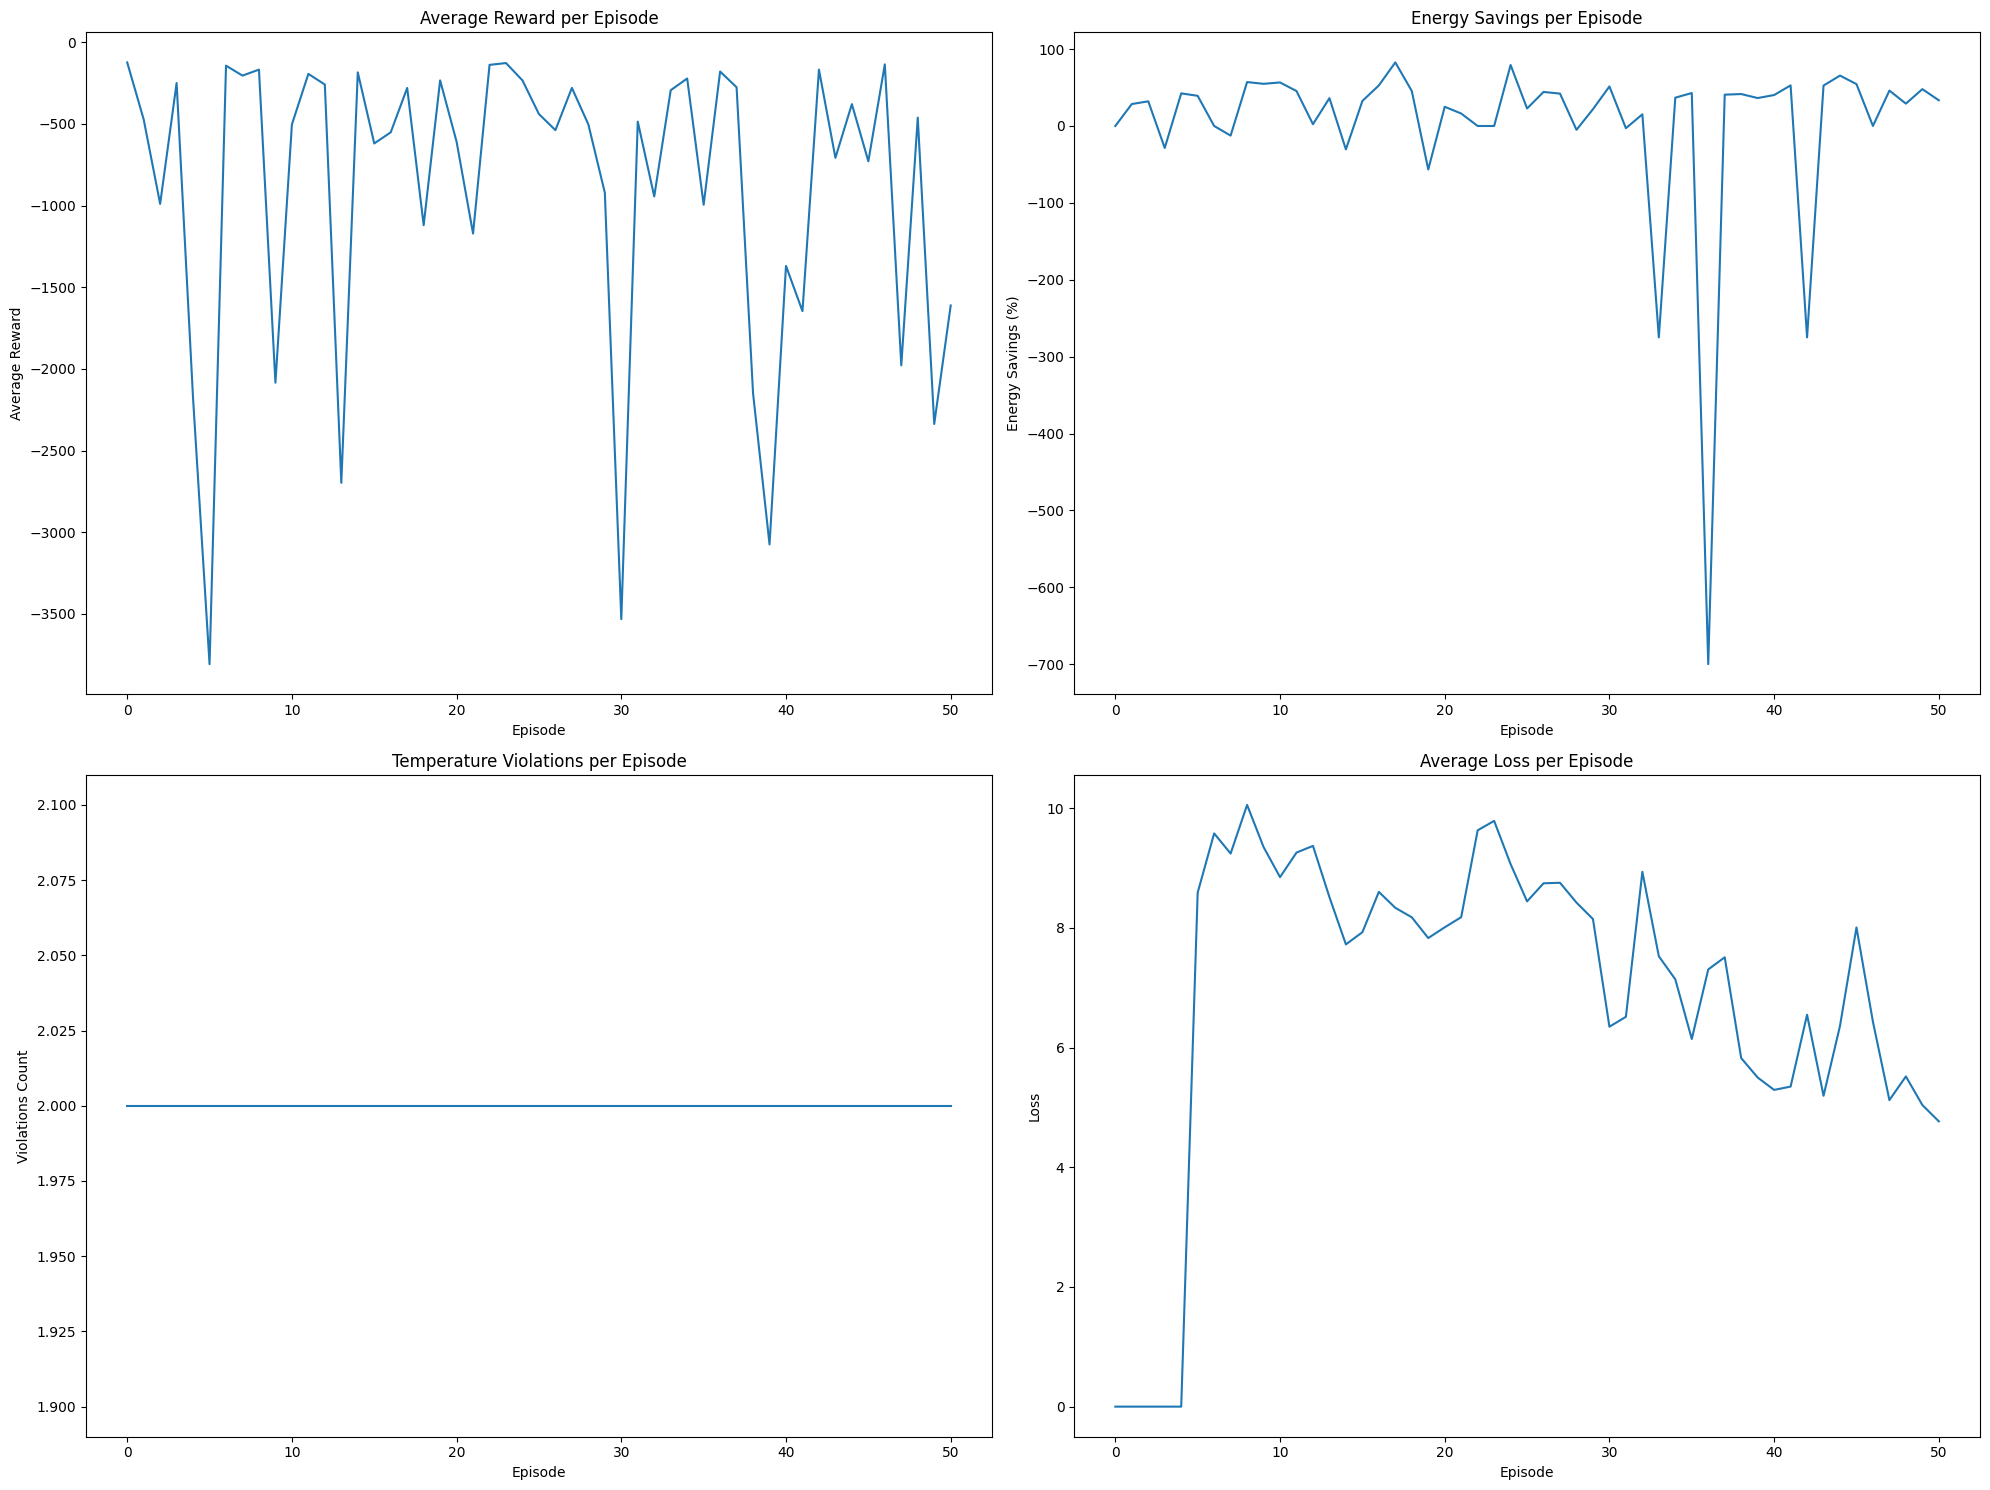

Starting one-year evaluation...


Evaluating Environment 1: 100%|██████████| 525600/525600 [15:10<00:00, 577.03it/s]



Evaluation Results:
Total Energy Saving: 66.76%
Total Temperature Violations: 825222

Per-Agent Performance:

Agent 0:
Energy Saving: 72.94%
Temperature Violations: 299723

Agent 1:
Energy Saving: 60.55%
Temperature Violations: 525499


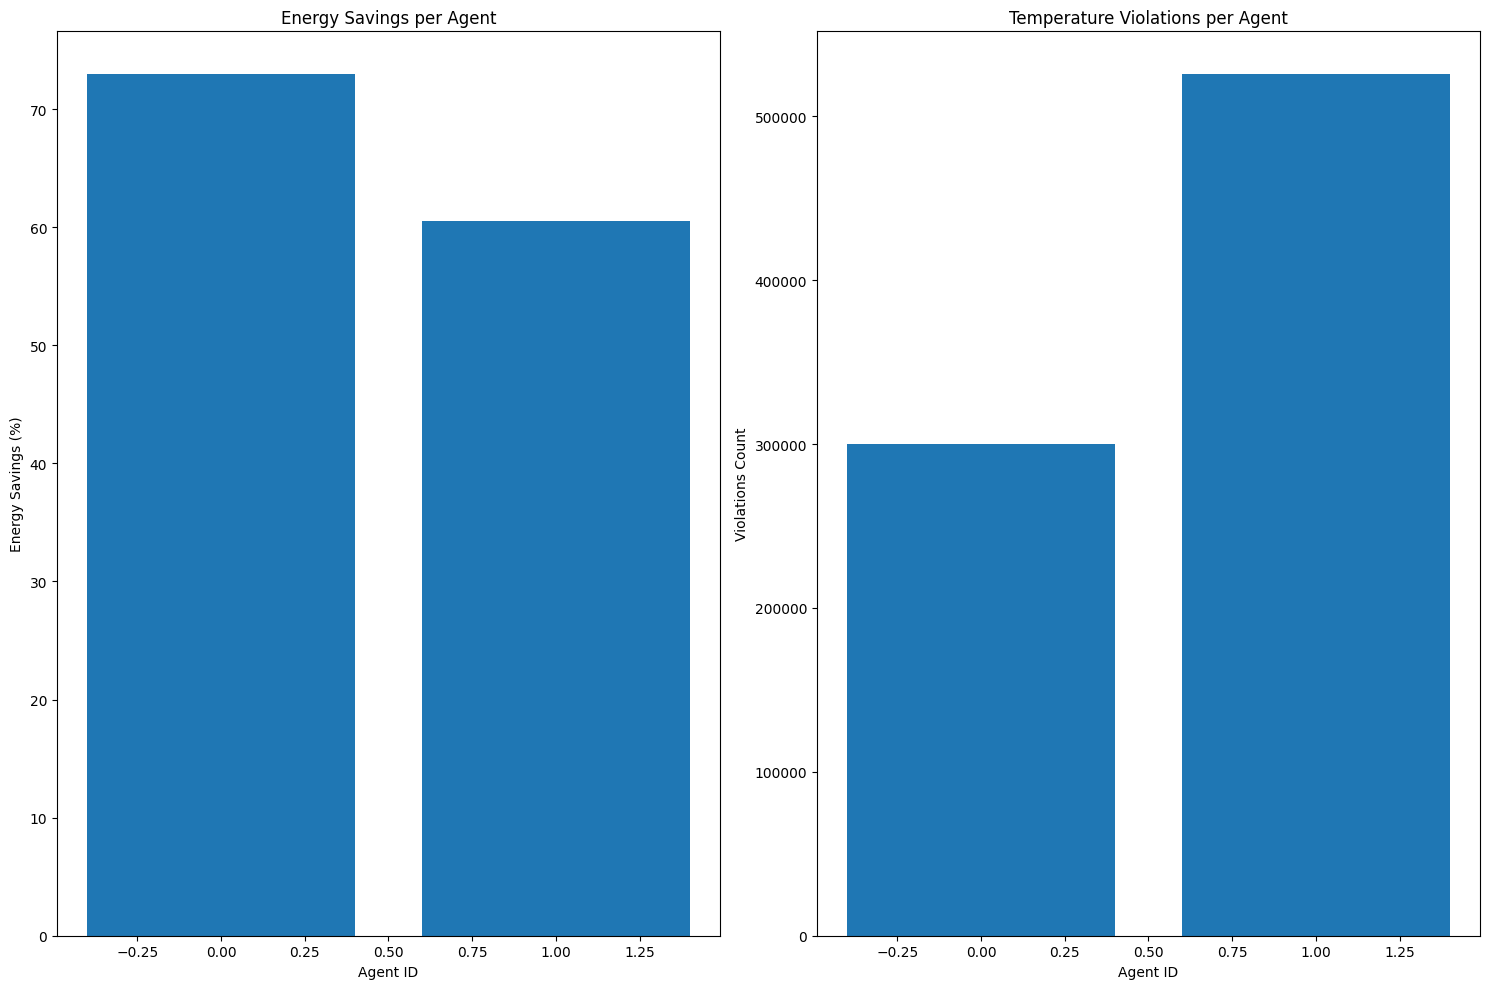


Training and evaluation completed. Results saved to 'federated_learning_results.pkl'


In [1]:
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import Huber
from collections import deque
import pickle
import threading
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

class DataCenterEnvironment:
    def __init__(self, dc_id, optimal_temperature=(18.0, 24.0), initial_month=0,
                 initial_number_users=10, initial_rate_data=60):
        self.dc_id = dc_id
        self.initial_month = initial_month
        self.monthly_atmospheric_temperatures = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0,
                                                 23.0, 24.0, 22.0, 10.0, 5.0, 1.0]

        # Temperature parameters
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[initial_month]
        self.optimal_temperature = optimal_temperature
        self.min_temperature = -20
        self.max_temperature = 80

        # User load parameters
        self.min_number_users = 10
        self.max_number_users = 100
        self.max_update_users = 5
        self.initial_number_users = initial_number_users
        self.current_number_users = initial_number_users

        # Data rate parameters
        self.min_rate_data = 20
        self.max_rate_data = 300
        self.max_update_data = 10
        self.initial_rate_data = initial_rate_data
        self.current_rate_data = initial_rate_data

        # Temperature calculations
        self.intrinsic_temperature = self.calculate_intrinsic_temperature()
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = sum(optimal_temperature) / 2.0

        # Energy tracking
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0

        # State tracking
        self.reward = 0.0
        self.game_over = 0
        self.train = 1

        # Local performance metrics
        self.performance_history = {
            'energy_savings': [],
            'temperature_violations': 0,
            'average_reward': 0.0
        }

    def calculate_intrinsic_temperature(self):
        return (self.atmospheric_temperature +
                1.25 * self.current_number_users +
                1.25 * self.current_rate_data)

    def update_env(self, direction, energy_ai, month):
        energy_noai = self.calculate_noai_energy()

        # Improved reward function
        temperature_penalty = 0
        if self.temperature_ai < self.optimal_temperature[0]:
            temperature_penalty = (self.optimal_temperature[0] - self.temperature_ai) * 2
        elif self.temperature_ai > self.optimal_temperature[1]:
            temperature_penalty = (self.temperature_ai - self.optimal_temperature[1]) * 2

        energy_saving = (energy_noai - energy_ai) / 100
        self.reward = energy_saving - temperature_penalty

        self.update_environmental_conditions(month)
        delta_temp = self.calculate_temperature_changes(direction, energy_ai)
        self.update_temperatures(delta_temp)
        self.check_game_over()

        self.total_energy_ai += energy_ai
        self.total_energy_noai += energy_noai

        return self.get_normalized_state(), self.reward, self.game_over

    def calculate_noai_energy(self):
        energy_noai = 0
        if self.temperature_noai < self.optimal_temperature[0]:
            energy_noai = self.optimal_temperature[0] - self.temperature_noai
            self.temperature_noai = self.optimal_temperature[0]
        elif self.temperature_noai > self.optimal_temperature[1]:
            energy_noai = self.temperature_noai - self.optimal_temperature[1]
            self.temperature_noai = self.optimal_temperature[1]
        return energy_noai

    def update_environmental_conditions(self, month):
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[month]
        self.update_users()
        self.update_data_rate()

    def update_users(self):
        self.current_number_users += np.random.randint(-self.max_update_users,
                                                       self.max_update_users)
        self.current_number_users = np.clip(self.current_number_users,
                                            self.min_number_users,
                                            self.max_number_users)

    def update_data_rate(self):
        self.current_rate_data += np.random.randint(-self.max_update_data,
                                                    self.max_update_data)
        self.current_rate_data = np.clip(self.current_rate_data,
                                         self.min_rate_data,
                                         self.max_rate_data)

    def calculate_temperature_changes(self, direction, energy_ai):
        past_intrinsic_temperature = self.intrinsic_temperature
        self.intrinsic_temperature = self.calculate_intrinsic_temperature()
        delta_intrinsic = self.intrinsic_temperature - past_intrinsic_temperature
        delta_ai = -energy_ai if direction == -1 else energy_ai
        return {'intrinsic': delta_intrinsic, 'ai': delta_ai}

    def update_temperatures(self, delta_temp):
        self.temperature_ai += delta_temp['intrinsic'] + delta_temp['ai']
        self.temperature_noai += delta_temp['intrinsic']

    def check_game_over(self):
        if self.temperature_ai < self.min_temperature or self.temperature_ai > self.max_temperature:
            self.performance_history['temperature_violations'] += 1
            if self.train:
                self.game_over = 1
            else:
                self.handle_temperature_violation('cold' if self.temperature_ai < self.min_temperature else 'hot')

    def handle_temperature_violation(self, violation_type):
        if violation_type == 'cold':
            self.total_energy_ai += self.optimal_temperature[0] - self.temperature_ai
            self.temperature_ai = self.optimal_temperature[0]
        else:
            self.total_energy_ai += self.temperature_ai - self.optimal_temperature[1]
            self.temperature_ai = self.optimal_temperature[1]

    def get_normalized_state(self):
        return np.array([
            (self.temperature_ai - self.min_temperature) /
            (self.max_temperature - self.min_temperature),
            (self.current_number_users - self.min_number_users) /
            (self.max_number_users - self.min_number_users),
            (self.current_rate_data - self.min_rate_data) /
            (self.max_rate_data - self.min_rate_data)
        ])

    def reset(self, new_month):
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[new_month]
        self.initial_month = new_month
        self.current_number_users = self.initial_number_users
        self.current_rate_data = self.initial_rate_data
        self.intrinsic_temperature = self.calculate_intrinsic_temperature()
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = sum(self.optimal_temperature) / 2.0
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0
        self.reward = 0.0
        self.game_over = 0
        self.train = 1
        self.performance_history['temperature_violations'] = 0
        return self.get_normalized_state(), 0, 0

class FederatedBrain:
    def __init__(self, state_size=3, learning_rate=0.0005, number_actions=5):
        self.state_size = state_size
        self.learning_rate = learning_rate
        self.number_actions = number_actions
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        with tf.device('/CPU:0'):
            model = keras.Sequential([
                keras.layers.Input(shape=(self.state_size,)),
                keras.layers.Dense(128, activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Reshape((1, 64)),
                keras.layers.LSTM(64),
                keras.layers.Dense(self.number_actions, activation='linear')
            ])

            model.compile(loss=Huber(), optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        self.model.set_weights(weights)

class FederatedDQN:
    def __init__(self, state_size=3, action_size=5, memory_size=50000):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.0005
        self.update_target_freq = 5
        self.brain = FederatedBrain(state_size, self.learning_rate, action_size)
        self.training_metrics = {
            'losses': [],
            'rewards': [],
            'epsilons': []
        }

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    @tf.function
    def _predict(self, state):
        return self.brain.model(state)

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state_tensor = tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)
        act_values = self._predict(state_tensor)

        if self.epsilon > self.epsilon_min:
            noise = tf.random.normal(shape=act_values.shape, mean=0, stddev=0.1)
            act_values += noise

        return tf.argmax(act_values[0]).numpy()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return 0

        minibatch = random.sample(self.memory, batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma * (np.amax(self.brain.target_model.predict_on_batch(next_states), axis=1)) * (1 - dones)
        targets_full = self.brain.model.predict_on_batch(states)

        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [actions]] = targets

        history = self.brain.model.fit(states, targets_full, epochs=1, verbose=0)
        loss = history.history['loss'][0]

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.training_metrics['losses'].append(loss)
        self.training_metrics['epsilons'].append(self.epsilon)

        return loss

class FederatedLearningCoordinator:
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.agents = []
        self.global_weights = None
        self.performance_metrics = {
            'global_energy_savings': [],
            'agent_performance': {}
        }

    def initialize_agents(self):
        for i in range(self.num_agents):
            agent = FederatedDQN()
            self.agents.append(agent)
            self.performance_metrics['agent_performance'][i] = {
                'energy_savings': [],
                'rewards': [],
                'losses': []
            }

    def aggregate_weights(self):
        weights = [agent.brain.get_weights() for agent in self.agents]
        new_weights = [np.zeros_like(w) for w in weights[0]]

        for agent_weights in weights:
            for i in range(len(new_weights)):
                new_weights[i] += agent_weights[i] / self.num_agents

        self.global_weights = new_weights
        return new_weights

    def distribute_weights(self):
        for agent in self.agents:
            agent.brain.set_weights(self.global_weights)

    def update_metrics(self, agent_id, metrics):
        for key, value in metrics.items():
            self.performance_metrics['agent_performance'][agent_id][key].append(value)

def train_federated_system(coordinator, environments, episodes=1000,
                           steps_per_episode=5000, batch_size=128,
                           aggregation_frequency=5, patience=50,
                           min_delta=0.001):
    training_history = {
        'episode_rewards': [],
        'energy_savings': [],
        'temperature_violations': [],
        'losses': []
    }

    best_reward = float('-inf')
    patience_counter = 0
    best_weights = None

    for episode in tqdm(range(episodes), desc="Training Episodes"):
        episode_metrics = {
            'total_energy_ai': 0,
            'total_energy_noai': 0,
            'total_rewards': [],
            'losses': [],
            'temperature_violations': 0
        }

        for agent_id in range(coordinator.num_agents):
            env = environments[agent_id]
            agent = coordinator.agents[agent_id]

            current_month = np.random.randint(0, 12)
            state, _, _ = env.reset(current_month)
            total_reward = 0
            episode_losses = []

            for step in range(steps_per_episode):
                action = agent.act(state)
                next_state, reward, done = env.update_env(
                    direction=1 if action > 2 else -1,
                    energy_ai=abs(action - 2) * 1.5,
                    month=(current_month + step // (30 * 24 * 60)) % 12
                )

                agent.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                if len(agent.memory) > batch_size:
                    loss = agent.replay(batch_size)
                    episode_losses.append(loss)

                if done:
                    break

            energy_saving = 0
            if env.total_energy_noai > 0:
                energy_saving = (env.total_energy_noai - env.total_energy_ai) / env.total_energy_noai * 100

            coordinator.update_metrics(agent_id, {
                'rewards': total_reward,
                'losses': np.mean(episode_losses) if episode_losses else 0,
                'energy_savings': energy_saving
            })

            episode_metrics['total_energy_ai'] += env.total_energy_ai
            episode_metrics['total_energy_noai'] += env.total_energy_noai
            episode_metrics['total_rewards'].append(total_reward)
            episode_metrics['losses'].extend(episode_losses)
            episode_metrics['temperature_violations'] += env.performance_history['temperature_violations']

        if episode % aggregation_frequency == 0:
            new_weights = coordinator.aggregate_weights()
            coordinator.distribute_weights()

        total_energy_saving = 0
        if episode_metrics['total_energy_noai'] > 0:
            total_energy_saving = ((episode_metrics['total_energy_noai'] -
                                  episode_metrics['total_energy_ai']) /
                                 episode_metrics['total_energy_noai'] * 100)

        avg_reward = np.mean(episode_metrics['total_rewards'])
        training_history['episode_rewards'].append(avg_reward)
        training_history['energy_savings'].append(total_energy_saving)
        training_history['temperature_violations'].append(episode_metrics['temperature_violations'])
        training_history['losses'].append(np.mean(episode_metrics['losses']) if episode_metrics['losses'] else 0)

        # Early stopping check
        if avg_reward > best_reward + min_delta:
            best_reward = avg_reward
            patience_counter = 0
            best_weights = coordinator.global_weights
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at episode {episode}")
            coordinator.global_weights = best_weights
            coordinator.distribute_weights()
            break

        # Learning rate decay
        if episode % 100 == 0 and episode > 0:
            for agent in coordinator.agents:
                current_lr = agent.brain.model.optimizer.learning_rate
                if isinstance(current_lr, tf.keras.optimizers.schedules.LearningRateSchedule):
                    print("Learning rate is using a schedule. Manual decay not applied.")
                else:
                    new_lr = max(current_lr * 0.9, 1e-6)
                    agent.brain.model.optimizer.learning_rate.assign(new_lr)

        # Save the best model for each agent after each episode
        for agent_id, agent in enumerate(coordinator.agents):
            agent.brain.model.save(f'best_model_agent_{agent_id}.keras')

    return training_history

def evaluate_federated_system(coordinator, environments, evaluation_steps=525600):
    print("Starting one-year evaluation...")

    evaluation_metrics = {
        'total_energy_ai': 0,
        'total_energy_noai': 0,
        'temperature_violations': 0,
        'agent_performance': {}
    }

    for agent_id, agent in enumerate(coordinator.agents):
        agent.brain.model = load_model(f'best_model_agent_{agent_id}.keras')
        agent.epsilon = 0
        evaluation_metrics['agent_performance'][agent_id] = {
            'energy_savings': [],
            'temperature_violations': 0
        }

    for env_id, env in enumerate(environments):
        env.train = False
        state, _, _ = env.reset(0)  # Start from January

        for step in tqdm(range(evaluation_steps), desc=f"Evaluating Environment {env_id}"):
            agent = coordinator.agents[env_id]
            action = agent.act(state)

            next_state, _, _ = env.update_env(
                direction=1 if action > 2 else -1,
                energy_ai=abs(action - 2) * 1.5,
                month=(step // (30 * 24 * 60)) % 12
            )

            state = next_state

        evaluation_metrics['total_energy_ai'] += env.total_energy_ai
        evaluation_metrics['total_energy_noai'] += env.total_energy_noai
        evaluation_metrics['temperature_violations'] += env.performance_history['temperature_violations']

        agent_saving = 0
        if env.total_energy_noai > 0:
            agent_saving = ((env.total_energy_noai - env.total_energy_ai) /
                           env.total_energy_noai * 100)
        evaluation_metrics['agent_performance'][env_id]['energy_savings'] = agent_saving
        evaluation_metrics['agent_performance'][env_id]['temperature_violations'] = \
            env.performance_history['temperature_violations']

    total_energy_saving = 0
    if evaluation_metrics['total_energy_noai'] > 0:
        total_energy_saving = ((evaluation_metrics['total_energy_noai'] -
                               evaluation_metrics['total_energy_ai']) /
                              evaluation_metrics['total_energy_noai'] * 100)

    print("\nEvaluation Results:")
    print(f"Total Energy Saving: {total_energy_saving:.2f}%")
    print(f"Total Temperature Violations: {evaluation_metrics['temperature_violations']}")
    print("\nPer-Agent Performance:")
    for agent_id, metrics in evaluation_metrics['agent_performance'].items():
        print(f"\nAgent {agent_id}:")
        print(f"Energy Saving: {metrics['energy_savings']:.2f}%")
        print(f"Temperature Violations: {metrics['temperature_violations']}")

    return evaluation_metrics

def plot_training_history(training_history):
    plt.figure(figsize=(20, 15))

    plt.subplot(2, 2, 1)
    plt.plot(training_history['episode_rewards'])
    plt.title('Average Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')

    plt.subplot(2, 2, 2)
    plt.plot(training_history['energy_savings'])
    plt.title('Energy Savings per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Energy Savings (%)')

    plt.subplot(2, 2, 3)
    plt.plot(training_history['temperature_violations'])
    plt.title('Temperature Violations per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Violations Count')

    plt.subplot(2, 2, 4)
    plt.plot(training_history['losses'])
    plt.title('Average Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()
def plot_evaluation_results(evaluation_metrics):
    agent_savings = [metrics['energy_savings'] for metrics in evaluation_metrics['agent_performance'].values()]
    agent_violations = [metrics['temperature_violations'] for metrics in evaluation_metrics['agent_performance'].values()]

    plt.figure(figsize=(15, 10))

    plt.subplot(1, 2, 1)
    plt.bar(range(len(agent_savings)), agent_savings)
    plt.title('Energy Savings per Agent')
    plt.xlabel('Agent ID')
    plt.ylabel('Energy Savings (%)')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(agent_violations)), agent_violations)
    plt.title('Temperature Violations per Agent')
    plt.xlabel('Agent ID')
    plt.ylabel('Violations Count')

    plt.tight_layout()
    plt.show()

def main():
    num_agents = 2
    episodes = 1000
    steps_per_episode = 5000
    batch_size = 128
    aggregation_frequency = 5

    coordinator = FederatedLearningCoordinator(num_agents)
    coordinator.initialize_agents()

    environments = []
    for i in range(num_agents):
        env = DataCenterEnvironment(
            dc_id=i,
            optimal_temperature=(18.0 + i*0.5, 24.0 + i*0.5),
            initial_number_users=20 + i*5,
            initial_rate_data=30 + i*10
        )
        environments.append(env)

    print("Starting federated training...")
    training_history = train_federated_system(
        coordinator=coordinator,
        environments=environments,
        episodes=episodes,
        steps_per_episode=steps_per_episode,
        batch_size=batch_size,
        aggregation_frequency=aggregation_frequency
    )

    plot_training_history(training_history)

    evaluation_metrics = evaluate_federated_system(coordinator, environments)

    plot_evaluation_results(evaluation_metrics)

    results = {
        'training_history': training_history,
        'training_metrics': coordinator.performance_metrics,
        'evaluation_metrics': evaluation_metrics
    }

    with open('federated_learning_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("\nTraining and evaluation completed. Results saved to 'federated_learning_results.pkl'")


if __name__ == "__main__":
    main()